In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import dvu
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import imodelsx.process_results
import ridge_utils.features.qa_questions
import joblib
from tqdm import tqdm
import analyze_helper
fit_encoding = __import__('02_fit_encoding')
dvu.set_style()

results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/results_apr7'
r, cols_varied, mets = analyze_helper.load_clean_results(results_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 301/301 [00:49<00:00,  6.13it/s]

experiment varied these params: ['subject', 'feature_space', 'distill_model_path', 'feature_selection_alpha_index', 'qa_embedding_model', 'qa_questions_version', 'pc_components', 'ndelays', 'seed']


### Validate model weights usage

In [6]:
args = r[(r.pc_components == 100) * (r.ndelays == 8) * (r.feature_space.str.contains('qa_emb'))
         ].sort_values(by='corrs_test_mean').iloc[-1]

In [ ]:
args

In [ ]:
stim_test_delayed = fit_encoding.get_features_full(
    args, 'meta-llama/Meta-Llama-3-8B-Instruct', ['sloth'])

In [ ]:
args.pc_components = 0
resp_train, resp_test = fit_encoding.get_resps_full(
    args, args.subject, ['sloth'], ['sloth'])

In [ ]:
model_params = joblib.load(
    join(args.save_dir_unique, 'model_params.pkl'))
print(args.feature_space, args.pc_components, args.ndelays)

In [ ]:
wt = model_params['weights']
preds_test = stim_test_delayed @ wt

In [33]:
preds_test.shape

(437, 95556)

### Validate corrs

In [ ]:
def _calc_corrs(preds, resp):
    corrs = []
    for i in tqdm(range(preds.shape[1])):
        corrs.append(np.corrcoef(
            preds[:, i], resp[:, i])[0, 1])
    return np.array(corrs)


wt = model_params['weights']
preds_test = stim_test_delayed @ wt
corrs_test = _calc_corrs(preds_test, resp_test)
print(np.mean(corrs_test))
print(args.corrs_test_mean)
assert np.allclose(corrs_test, args['corrs_test'])

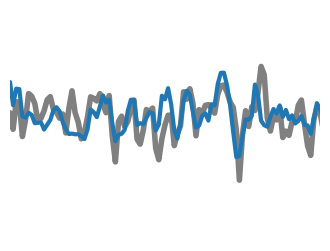

In [56]:
a = np.argmax(corrs_test)
preds_voxel_best = preds_test[:, a]
resp_voxel_best = resp_test[:, a]
plt.figure(figsize=(4, 3))
plt.plot(resp_voxel_best / np.std(resp_voxel_best), color='gray', lw=4)
plt.plot(preds_voxel_best / np.std(preds_voxel_best) /
         1.2, color='C0', lw=3)  # , resp_voxel_best, 'o')
plt.xlim((250, 350))
plt.ylim((-6, 5))
plt.xticks([])
plt.yticks([])
# remove all splines
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.savefig('../figs/ex_curve.pdf', bbox_inches='tight')

In [ ]:
wt = model_params['weights']
# + model_params_to_save['bias'] (not needed for just calculating corr, but needed for predictions)
preds_test = stim_test_delayed @ wt

corrs_test = _calc_corrs(preds_test, resp_test)
print(np.mean(corrs_test))
print(args.corrs_test_mean)
assert np.allclose(corrs_test, args['corrs_test'])

### Original setup, before we had unpacked weights

In [7]:
import ridge_utils.data.story_names
story_names_train = ridge_utils.data.story_names.get_story_names(
    subject='UTS03', train_or_test='train')
story_names_test = ridge_utils.data.story_names.get_story_names(
    subject='UTS03', train_or_test='test')

In [8]:
args.pc_components = 0
resp_train, resp_test = fit_encoding.get_resps_full(
    args, args.subject, story_names_train, story_names_test)

In [ ]:
wt_pc = model_params['weights_pc']
pca = model_params['pca']
scaler_test = model_params['scaler_test']
preds_pc = stim_test_delayed @ wt_pc
preds_pc_scaled = scaler_test.inverse_transform(preds_pc)
preds_voxels = pca.inverse_transform(preds_pc_scaled)
corrs_test = _calc_corrs(preds_voxels, resp_test)
assert np.allclose(corrs_test, args['corrs_test'])

In [ ]:
# Vary number of pcs included
num_pcs = [5, 25, 50, 100, 200, 500, 1000]
corrs = []
for num_pc in num_pcs:
    wt_pc = model_params['weights_pc']
    pca = model_params['pca']
    scaler_test = model_params['scaler_test']
    preds_pc = stim_test_delayed @ wt_pc
    preds_pc_scaled = scaler_test.inverse_transform(preds_pc)

    pca_subset = deepcopy(pca)
    pca_subset.components_[num_pc:] = 0
    preds_voxels = pca_subset.inverse_transform(preds_pc_scaled)

    corrs_test = _calc_corrs(preds_voxels, resp_test)
    # assert np.allclose(corrs_test, args['corrs_test'])
    print(num_pc, np.mean(corrs_test))
    corrs.append(np.mean(corrs_test))
plt.plot(num_pcs, corrs)

In [ ]:
corrs_test = fit_encoding.evaluate_pc_model_on_each_voxel(
    args, stim_test_delayed, resp_test,
    model_params, pca, scaler_test)

In [ ]:
wt = model_params['weights']

# multiply
preds_pc = stim_test_delayed @ wt
preds_pc_unscaled = preds_pc * scaler_test.scale_ + scaler_test.mean_
preds_voxels2 = preds_pc_unscaled @ pca.components_ + pca.mean_

# rewrite the above as a multiplication of a single weight matrix
preds_voxels2 = (stim_test_delayed @ wt * scaler_test.scale_ +
                 scaler_test.mean_) @ pca.components_ + pca.mean_
weight_full = wt * scaler_test.scale_ @ pca.components_
bias_full = scaler_test.mean_ @ pca.components_ + pca.mean_
preds_voxels2 = stim_test_delayed @ weight_full + bias_full

assert np.allclose(preds_voxels, preds_voxels2)

In [ ]:
assert corrs_test.mean() == args.corrs_test_mean